---
title: "[gene expression] 1. 모든 암 유전자 발현 데이터에 대한 오토인코더 사전 학습" 
author: "agsu" 
date: "11/16/2023" 
format: html: 
code-fold: false 
jupyter: python3 
categories: [project, gene expression] 
image: ../image/gene1.png
---

# **1. 모든 암 유전자 발현 데이터에 대한 오토인코더 사전 학습** 

본 글에서는 유방암의 분자적 아종 분류의 성능 향상을 위해 모든 종류의 암 유전자 발현 데이터에 대한 사전 학습을 진행한다. 암 데이터셋은 TCGA(The Cancer Genome Atlas)데이터이고, firebrowse 웹 사이트에서 다운로드 받아 사용하였다.

<br> 

In [1]:
import os
from tqdm import tqdm 

import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

<br> 

## **1.1 The Cancer Genome Atlas사전학습 데이터(전체 암 데이터) 전처리** 

LUAD(폐선암)을 예로 들어 확인해보면, 사용할 유전자 발현 데이터는 다음과 같은 형태를 띄고 있다. 

In [5]:
data_luad = pd.read_csv("./data/LUAD.txt", delimiter="\t", skiprows=lambda x: x==1)
display(data_luad.head())
print(data_luad.shape)

,Hybridization REF,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,TCGA-05-4396-01A-21R-1858-07,...,TCGA-NJ-A4YG-01A-22R-A262-07,TCGA-NJ-A4YI-01A-11R-A262-07,TCGA-NJ-A4YP-01A-11R-A262-07,TCGA-NJ-A4YQ-01A-11R-A262-07,TCGA-NJ-A55A-01A-11R-A262-07,TCGA-NJ-A55O-01A-11R-A262-07,TCGA-NJ-A55R-01A-11R-A262-07,TCGA-NJ-A7XG-01A-12R-A39D-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-S2-AA1A-01A-12R-A39D-07
0,?|100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,?|100133144,10.0113,7.1957,7.2453,11.3311,3.2254,4.0000,7.1084,3.4360,13.5406,...,11.7148,3.6657,2.3298,16.3214,20.3514,15.5193,8.4195,42.9857,14.0861,20.5338
2,?|100134869,11.2820,12.4436,6.0184,7.5740,3.4942,13.7852,7.5810,12.1335,16.0273,...,11.9573,9.7617,8.3410,7.5330,17.2393,22.9872,10.3226,81.1128,24.1914,8.9500
3,?|10357,49.5994,90.5117,49.5366,82.8303,72.5351,66.3658,109.1809,57.0596,108.4155,...,163.5739,130.7486,101.7403,82.4231,100.4196,100.1867,74.7210,85.3715,61.1388,76.9265
4,?|10431,848.9397,924.0158,1140.6781,807.1729,562.0037,1342.6174,1148.3315,955.9141,844.5792,...,919.1686,403.4911,918.9533,995.6058,536.7602,873.9790,766.7448,677.7333,1137.3206,565.4335


(20531, 577)


Hybridization REF 컬럼은 유전자의 종류이고, 나머지 컬럼들은 환자의 정보다. 폐선암 데이터는 577 환자에 대하여 20531개의 유전자 정보를 담고 있음을 뜻한다. 모든 암은 20531개의 유전자와 서로 다른 환자의 정보를 담고 있으므로, 학습 데이터셋을 생성할 때는 20531개의 유전자를 특성으로 하는 환자 샘플 데이터로 변형해 준다. 

<br> 

### **1) 전체 암 데이터 병합** 
따하서 환자를 row로, 유전자를 column으로 Transpose 한 뒤, 모든 종류의 암 데이터를 모두 합친다. 

In [3]:
data = pd.DataFrame() 
for i, f in enumerate(glob.glob('./data/*.txt')):
    df = pd.read_csv(f, delimiter="\t", skiprows=lambda x: x==1)
    df = df.set_index("Hybridization REF")
    df = df.drop(columns=df.select_dtypes(include="object").columns) # 데이터가 float 형이 아닌 columns 제거 
    df = df.T
    df['cancer'] = str(f).split('/')[-1].split('.')[0]    
    data = pd.concat([data, df], axis=0)
    print(f'{i}th file {f} end')

data

0th file ./data/TGCT.txt end
1th file ./data/KICH.txt end
2th file ./data/ACC.txt end
3th file ./data/LAML.txt end
4th file ./data/UVM.txt end
5th file ./data/SARC.txt end
6th file ./data/SKCM.txt end
7th file ./data/CHOL.txt end
8th file ./data/PAAD.txt end
9th file ./data/UCS.txt end
10th file ./data/CESC.txt end
11th file ./data/LGG.txt end
12th file ./data/BRCA.txt end
13th file ./data/STAD.txt end
14th file ./data/DLBC.txt end
15th file ./data/READ.txt end
16th file ./data/KIRP.txt end
17th file ./data/HNSC.txt end
18th file ./data/THCA.txt end
19th file ./data/THYM.txt end
20th file ./data/GBMLGG.txt end
21th file ./data/LIHC.txt end
22th file ./data/KIPAN.txt end
23th file ./data/STES.txt end
24th file ./data/GBM.txt end
25th file ./data/PCPG.txt end
26th file ./data/LUSC.txt end
27th file ./data/BLCA.txt end
28th file ./data/COAD.txt end
29th file ./data/ESCA.txt end
30th file ./data/OV.txt end
31th file ./data/UCEC.txt end
32th file ./data/PRAD.txt end
33th file ./data/LUAD.tx

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,cancer
TCGA-2G-AAEW-01A-11R-A430-07,0.0,1.212900e+02,8.371000e+01,215.630000,3744.000000,0.0,624.000000,0.000000e+00,0.000000e+00,0.0,...,986.000000,4735.000000,2.055000e+03,3625.000000,26336.000000,4296.000000,2056.000000,3163.000000,0.000000e+00,TGCT
TCGA-2G-AAEW-01A-11R-A430-07.1,0.0,3.159111e-06,1.587859e-06,0.000013,0.000102,0.0,0.000006,0.000000e+00,0.000000e+00,0.0,...,0.000005,0.000025,1.434327e-05,0.000014,0.000367,0.000012,0.000017,0.000063,0.000000e+00,TGCT
TCGA-2G-AAEX-01A-11R-A430-07,0.0,3.713000e+01,1.387000e+01,206.720000,4124.000000,0.0,230.000000,0.000000e+00,1.000000e+00,0.0,...,557.000000,2261.000000,3.133000e+03,2524.000000,15699.000000,2930.000000,1517.000000,5291.000000,0.000000e+00,TGCT
TCGA-2G-AAEX-01A-11R-A430-07.1,0.0,1.081522e-06,2.944248e-07,0.000013,0.000125,0.0,0.000003,0.000000e+00,2.789167e-08,0.0,...,0.000003,0.000015,2.517840e-05,0.000011,0.000250,0.000009,0.000014,0.000120,0.000000e+00,TGCT
TCGA-2G-AAF1-01A-11R-A430-07,0.0,8.208000e+01,5.892000e+01,159.620000,2442.000000,0.0,404.000000,0.000000e+00,1.000000e+00,0.0,...,944.000000,3775.000000,1.989000e+03,3841.000000,14313.000000,4323.000000,1722.000000,2283.000000,0.000000e+00,TGCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AG-A02X-01A-01R-A00A-07.1,0.0,1.936868e-06,7.455412e-07,0.000076,0.000059,0.0,0.000005,0.000000e+00,0.000000e+00,0.0,...,0.000006,0.000023,0.000000e+00,0.000005,0.000211,0.000015,0.000016,0.000007,0.000000e+00,COADREAD
TCGA-AG-A032-01A-01R-A00A-07,0.0,1.575000e+01,2.925000e+01,505.660000,821.000000,0.0,266.000000,1.000000e+00,0.000000e+00,0.0,...,790.000000,758.000000,2.000000e+00,416.000000,4261.000000,1889.000000,257.000000,27.000000,2.000000e+00,COADREAD
TCGA-AG-A032-01A-01R-A00A-07.1,0.0,9.840156e-07,1.362753e-06,0.000064,0.000054,0.0,0.000007,1.509079e-07,0.000000e+00,0.0,...,0.000010,0.000010,4.110094e-08,0.000004,0.000152,0.000013,0.000005,0.000002,1.573806e-07,COADREAD
TCGA-AG-A036-01A-12R-A083-07,0.0,4.249000e+01,1.551000e+01,626.860000,1030.000000,0.0,193.000000,0.000000e+00,0.000000e+00,0.0,...,323.000000,1246.000000,8.000000e+00,533.000000,3078.000000,1007.000000,883.000000,215.000000,0.000000e+00,COADREAD


<br> 

### **2) 데이터 스케일링** 
전체 데이터에 log1p (즉, log(x+1)) 스케일링을 적용한다.

In [9]:
data.iloc[:,:-1] = data.iloc[:,:-1].apply(np.log1p)
data.to_parquet("data/merged_data_log1p.parquet")
data.head()

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,cancer
index,,,,,,,,,,,,,,,,,,,,,
TCGA-2G-AAEW-01A-11R-A430-07,0.0,4.806395,4.439234e+00,5.378191,8.228177,0.0,6.437752,0.0,0.000000e+00,0.0,...,6.894670,8.462948,7.628518,8.195885,10.178730,8.365672,7.629004,8.059592,0.0,TGCT
TCGA-2G-AAEW-01A-11R-A430-07.1,0.0,0.000003,1.587858e-06,0.000013,0.000102,0.0,0.000006,0.0,0.000000e+00,0.0,...,0.000005,0.000025,0.000014,0.000014,0.000367,0.000012,0.000017,0.000063,0.0,TGCT
TCGA-2G-AAEX-01A-11R-A430-07,0.0,3.641001,2.699346e+00,5.336191,8.324821,0.0,5.442418,0.0,6.931472e-01,0.0,...,6.324359,7.724005,8.050065,7.833996,9.661416,7.983099,7.325149,8.573952,0.0,TGCT
TCGA-2G-AAEX-01A-11R-A430-07.1,0.0,0.000001,2.944248e-07,0.000013,0.000125,0.0,0.000003,0.0,2.789166e-08,0.0,...,0.000003,0.000015,0.000025,0.000011,0.000250,0.000009,0.000014,0.000120,0.0,TGCT
TCGA-2G-AAF1-01A-11R-A430-07,0.0,4.419804,4.093010e+00,5.079041,7.800982,0.0,6.003887,0.0,6.931472e-01,0.0,...,6.851185,8.236421,7.595890,8.253748,9.568993,8.371936,7.451822,7.733684,0.0,TGCT


<br> 
<br> 

## 1.2 **오토인코더(Autoencoder) 사전학습** 

사전학습에는 입력 데이터를 압축하고 복원하는 과정에서 중요한 특성을 학습하는 모델인 오토 인코더(Autoencoder)를 사용하였다.

### **1) 학습/검증 데이터셋 정의** 
오토인코더 사전학습 모델에 사용할 train, validation 데이터셋을 정의한다. 

In [ ]:
# 병합 데이터 불러오기 
data = pd.read_parquet("data/merged_data_log1p.parquet")
data.head(3)

In [ ]:
batch_size = 256

data_allcancer = data.drop('cancer', axis=1)
train, valid = train_test_split(data_allcancer, test_size=0.2, random_state=42)

dataset_train = TensorDataset(torch.tensor(train.to_numpy(), dtype=torch.float32))
dataset_valid = TensorDataset(torch.tensor(valid.to_numpy(), dtype=torch.float32))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)

<br> 

### **2) 모델 학습 함수 정의** 
여러 구조의 모델을 학습 시킬 예정이므로, PyTorch 프레임워크를 사용하여 모델을 학습하는 함수를 정의한다. 

In [4]:
# 모델 훈련
def train_auto_encoder(model, model_name, dataloader_train, dataloader_valid, lr=0.001, num_epochs=200, patience=20):
    # 손실 함수와 옵티마이저 설정
    criterion = nn.MSELoss()  # 평균 제곱 오차 손실 함수
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Early Stopping 설정
    early_stopping = {
        'patience': patience,  # 연속으로 검증 손실이 줄어들지 않는 횟수
        'counter': 0,   # 현재 연속으로 검증 손실이 줄어들지 않은 횟수
        'epoch': 0,
        'best_loss_val': float('inf'),  # 현재까지의 최적 검증 손실
        'best_loss': float('inf')  # 최적 검증 손실일 때, 학습 손실                
    } 

    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train() 
        batch_loss = 0 
        batch_train = 0
        for inputs in dataloader_train:
            inputs = inputs[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            batch_loss += loss.item() 
            batch_train += 1

        model.eval()
        batch_loss_val = 0
        batch_val = 0    
        with torch.no_grad():
            for valid_inputs in dataloader_valid:
                valid_inputs = valid_inputs[0].to(device)
                valid_outputs = model(valid_inputs)

                batch_loss_val += criterion(valid_outputs, valid_inputs).item()
                batch_val += 1
                
        train_losses.append(batch_loss / batch_train)
        val_losses.append(batch_loss_val / batch_val)
        print(f"{model_name}, Epoch [{epoch + 1}/{num_epochs}] Loss: {batch_loss/batch_train:.4f} Loss_val: {batch_loss_val/batch_val:.4f}")

        if batch_loss_val/batch_val < early_stopping['best_loss_val']:
            early_stopping['best_loss'] = batch_loss / batch_train
            early_stopping['best_loss_val'] = batch_loss_val / batch_val
            early_stopping['counter'] = 0
            early_stopping['epoch'] = epoch
            torch.save(model, f"model_zscore/{model_name}.pth")
        else:
            if early_stopping['counter'] >= early_stopping['patience']:
                print("Early Stopping: Training stopped.")
                break  # 훈련 중단
            early_stopping['counter'] += 1
        
        model = torch.load(f"model_zscore/{model_name}.pth")
    return model, train_losses, val_losses

In [5]:
# device 설정 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<br> 

### 3) **오토 인코더 모델 정의**
오토 인코더는 다음 그림과 같은 6가지의 구조로 설계하였다. 
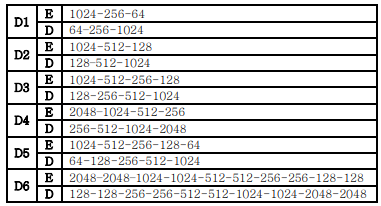

다음은 오토 인코더의 6가지 구조를 정의한 코드이다. 

In [ ]:
##### Autoencoder1 #####
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가            
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가    
            nn.Linear(256, 64),            
            nn.ReLU(),
            nn.BatchNorm1d(64),  # 배치 정규화 추가              
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가                 
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가                 
            nn.Linear(1024, 20531)       
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
##### Autoencoder2 #####
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
##### Autoencoder3 #####
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531),            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
    
##### Autoencoder4 #####
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

    
##### Autoencoder5 #####    
class Autoencoder5(nn.Module):
    def __init__(self):
        super(Autoencoder5, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


##### Autoencoder6 #####
class Autoencoder6(nn.Module):
    def __init__(self):
        super(Autoencoder6, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가            
            nn.Linear(2048, 2048),
            nn.ReLU(),            
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 1024),
            nn.ReLU(),                   
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 512),
            nn.ReLU(),                   
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),                 
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 128),  # 압축된 표현의 차원
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 256),
            nn.ReLU(),        
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 256),
            nn.ReLU(),              
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 512),
            nn.ReLU(),            
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 1024),
            nn.ReLU(),            
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 2048),
            nn.ReLU(),            
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 20531)       
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<br> 

### **4) 모델 학습** 
모두 동일한 학습 조건인 learning rate는 0.00001, 에폭은 3000, early stopping의 patience는 30으로 설정하여 6개 모델에 대한 사전 학습을 진행하였다.

In [11]:
# 모델 초기화
autoencoder3 = Autoencoder3()

model, train_losses, val_losses = train_auto_encoder(
                    autoencoder3, 
                    "pretrained_autoencoder3", 
                    dataloader_train=dataloader_train, 
                    dataloader_valid=dataloader_valid, 
                    lr=0.00001, 
                    num_epochs=3000,
                    patience=30
                  )

pretrained_autoencoder3, Epoch [1/3000] Loss: 17.7792 Loss_val: 16.2778
pretrained_autoencoder3, Epoch [2/3000] Loss: 16.4830 Loss_val: 16.6663
pretrained_autoencoder3, Epoch [3/3000] Loss: 16.4940 Loss_val: 16.7533
pretrained_autoencoder3, Epoch [4/3000] Loss: 16.4927 Loss_val: 16.7126
pretrained_autoencoder3, Epoch [5/3000] Loss: 16.4819 Loss_val: 16.7832
pretrained_autoencoder3, Epoch [6/3000] Loss: 16.4824 Loss_val: 16.6772
pretrained_autoencoder3, Epoch [7/3000] Loss: 16.4863 Loss_val: 16.7108
pretrained_autoencoder3, Epoch [8/3000] Loss: 16.4777 Loss_val: 16.6570
pretrained_autoencoder3, Epoch [9/3000] Loss: 16.4953 Loss_val: 16.7196
pretrained_autoencoder3, Epoch [10/3000] Loss: 16.4934 Loss_val: 16.6605
pretrained_autoencoder3, Epoch [11/3000] Loss: 16.4784 Loss_val: 16.6863
pretrained_autoencoder3, Epoch [12/3000] Loss: 16.4926 Loss_val: 16.6834
pretrained_autoencoder3, Epoch [13/3000] Loss: 16.4905 Loss_val: 16.7033
pretrained_autoencoder3, Epoch [14/3000] Loss: 16.4948 Loss_

모두 같은 코드이므로 생략하고, 아래와 같이 6개의 사전학습 모델을 생성하였다. 

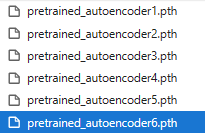

다음 글에서는 사전학습 된 모델의 가중치를 사용하여 미세조정하는 실험의 과정을 공유한다. 